In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, img_as_ubyte
from skimage.io import imread, imshow, imsave
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
from skimage import measure
import scipy.ndimage as ndimage  
from skimage.morphology import disk, binary_opening,disk
from scipy.spatial.distance import cdist
from skimage.transform import warp, estimate_transform, rotate
from scipy.ndimage import affine_transform

In [2]:
"""
A funciton that takes in a list of (x, y) pairs and uses 
the Shoelace formula to calculate the area of the polygon defined by the points.
@PARAMS points: a list of (x, y) pairs
@RETURN area: the area of the polygon defined by the points
"""
def calculate_polygon_area(points):
    # Get the number of points
    n = len(points)
    # Initialize area
    area = 0.0
    # For each point
    for i in range(n):
        # Get the current point
        x1, y1 = points[i]
        # Get the next point
        x2, y2 = points[(i + 1) % n]
        # Update the area using the Shoelace formula
        area += (x1 * y2) - (x2 * y1)
    # Divide the area by 2 as per the formula
    area /= 2.0
    
    #R eturn the absolute value of the area so that it is always positive
    return abs(area)

In [3]:
"""
A function that takes in a list of license plate coordinates (contour), greyscale image of the car, 
the rotation value, shear value and width and height of the output (correct) image - returns 
the cropped image of the license plate
@PARAMS plate_coords: contour points of the license plate, 
greyscale_car: greyscale image of the car, save_results = Whether or not to save the steps of the process,
width: width of the output image, height: height of the output image
@RETURN rotated_plate: the cropped image of the license plate
"""

def perspective_crop(plate_coords, greyscale_car, save_results, width = 800, height = 200):
    # Get the maximum and minimum of x and y coordinates of the license plate
    maxHeighht = np.max(plate_coords[:,0])
    minHeighht = np.min(plate_coords[:,0])
    maxWidth = np.max(plate_coords[:,1])
    minWidth = np.min(plate_coords[:,1])

    # Set the 4 relatives corners for the license plate 
    leftTop = [minHeighht, minWidth]
    rightTop = [minHeighht, maxWidth]
    leftBottom = [maxHeighht, minWidth]
    rightBottom = [maxHeighht, maxWidth]
    corners = [leftTop, rightTop, leftBottom, rightBottom]

    # Calculate the distance between the corners and the license plate coordinates
    distances = cdist(corners, plate_coords)
    # Get the index of the closest point for each corner
    closest_points_indices = np.argmin(distances, axis=1)
    # Get the closest license plate coordinates that represent the corners of the license plate
    closest_points = plate_coords[closest_points_indices]

    # Update the corners with the closest license plate coordinates
    leftTop = [closest_points[0][0]-60, minWidth-30]
    rightTop = [closest_points[1][0]-60, maxWidth+30]
    leftBottom = [closest_points[2][0]+60, minWidth-30]
    rightBottom = [closest_points[3][0]+60, maxWidth+30]
    corners = [leftTop, rightTop, leftBottom, rightBottom]

    # Calculate the distance between the new corners and the license plate coordinates
    distances = cdist(corners, plate_coords)
    # Get the index of the closest point for each new corner
    closest_points_indices = np.argmin(distances, axis=1)
    # Get the closest license plate coordinates that represent the corners of the license plate
    closest_points = plate_coords[closest_points_indices]
    
    # Get the coordinates of the corners of the output image
    corner_coordinates = np.array([(closest_points[0][1], closest_points[0][0]),(closest_points[1][1], closest_points[1][0]), (closest_points[3][1], closest_points[3][0]), (closest_points[2][1], closest_points[2][0])])
    # Get the target coordinates of the corners of the output image
    target_coordinates = np.array([(0, 0), (width, 0), (width, height), (0, height)])

    # Strecth the image to fit the output image
    transform = estimate_transform('projective', corner_coordinates, target_coordinates)

    # Warp the image to fit the output image and apply the rotation and shear
    segmented_plate = warp(greyscale_car, transform.inverse, output_shape=(height, width))

    # Save where the algorithm finds the corners displayed, save as step 10
    if save_results:
        plt.figure(figsize=(10,10))
        plt.imshow(greyscale_car, cmap='gray')
        plt.plot(corner_coordinates[0][0], corner_coordinates[0][1], 'ro')
        plt.plot(corner_coordinates[1][0], corner_coordinates[1][1], 'ro')
        plt.plot(corner_coordinates[2][0], corner_coordinates[2][1], 'ro')
        plt.plot(corner_coordinates[3][0], corner_coordinates[3][1], 'ro')
        plt.axis('off')
        plt.savefig('Figures/Steps/step9.png', bbox_inches='tight', pad_inches=0)
        plt.close()

    return segmented_plate

In [4]:
"""
A function that takes in an image of a car and returns the segmented license plate, with the given transformation correction values
@PARAMS input_image: the image of the car, save_results = Whether or not to save the steps of the process
@RETURN binary_plate: the segmented license plate
"""
def easy_segmenter(input_image, save_results = False):

    # Convert the RGB car image to greyscale and also remove the alpha channel
    greyscale_car = rgb2gray(input_image[:,:,:3])
    
    # Blur the image to remove noise using a gaussian filter with sigma = 4
    guassian_car = filters.gaussian(greyscale_car, sigma=4)

    # Get the edges of the image using the prewitt filter
    prewitt_car = filters.prewitt(guassian_car)
    
    # Threshold the image to convert it to binary using Otsus threshold algorithm 
    thresh_car = threshold_otsu(prewitt_car)
    binary_car = prewitt_car > thresh_car

    # Perform an opening on the binary image to remove small details and noise using a disk of radius 2 (CAN BE CHANGED TO IMPROVE RESULTS)
    opened_car = binary_opening(binary_car, disk(2))
    
    # Fill the holes in the image using region filling to get general shapes
    filled_car = ndimage.binary_fill_holes(opened_car)
    
    # Perform another opening to remove all smaller objects that were filled / not filled using a disk of radius 20 (CAN BE CHANGED TO IMPROVE RESULTS)``
    removed_small_car = binary_opening(filled_car, disk(20))
    
    # Find the contours of the image to get the coordinates of the perimeter of the shapes
    car_contours = measure.find_contours(removed_small_car, 0.8)
    
    # Sort the contours by their area in order to isolate the number plate shape from the others
    image_shapes = sorted(car_contours, key=calculate_polygon_area, reverse=True)

    # Using the perspective crop function, fit the licence plate to the output image and if not possible return a blank licence plate
    try:
        plate_cropped = perspective_crop(image_shapes[0], greyscale_car, save_results)
    except:
        plate_cropped = np.zeros((200,800))


    # Threshold the licence to convert it to binary using Otsus threshold algorithm
    plate_thresh = threshold_otsu(plate_cropped)
    binary_plate = plate_cropped > plate_thresh

    # Invert the binary image to get the licence plate in white and the background in black
    binary_plate = np.invert(binary_plate)

    # Run a closing on the binary_plate to remove small holes in the licence plate
    binary_plate = ndimage.binary_opening(binary_plate, disk(4))

    if save_results:
        # Save the  input as step 0  
        imsave('Figures/Steps/step0.png', img_as_ubyte(input_image))
        # Save the greyscale as step 1
        imsave('Figures/Steps/step1.png', img_as_ubyte(greyscale_car))
        # Save the reduced noise image as step 2
        imsave('Figures/Steps/step2.png', img_as_ubyte(guassian_car))
        # Save the edges as step 3
        imsave('Figures/Steps/step3.png', img_as_ubyte(prewitt_car))
        # Save the threshold image as step 4
        imsave('Figures/Steps/step4.png', img_as_ubyte(binary_car))
        # Save the opening output as step 5
        imsave('Figures/Steps/step5.png', img_as_ubyte(opened_car))
        # Save the filled image as step 6
        imsave('Figures/Steps/step6.png', img_as_ubyte(filled_car))
        # Save the opening output as step 7
        imsave('Figures/Steps/step7.png', img_as_ubyte(removed_small_car))
        # Save the cropped licence plate as step 10
        imsave('Figures/Steps/step10.png', img_as_ubyte(plate_cropped))
        # Save the binary licence plate as step 11
        imsave('Figures/Steps/step11.png', img_as_ubyte(binary_plate))
        # Plot the contours on removed_small_car and save it as step 8 without displaying the plot
        plt.figure(figsize=(10,10))
        plt.imshow(removed_small_car, cmap=plt.cm.gray)
        for n, contour in enumerate(image_shapes):
            plt.plot(contour[:, 1], contour[:, 0], linewidth=4)
        plt.axis('off')
        plt.savefig('Figures/Steps/step8.png', bbox_inches='tight', pad_inches=0)
        plt.close()

    # Return the result
    return binary_plate

In [125]:
# Get all images
car1 = imread('carplates/car0.png', as_gray=False)
car2 = imread('carplates/car1.png', as_gray=False)
car3 = imread('carplates/car2.png', as_gray=False)
car4 = imread('carplates/car3.png', as_gray=False)
# car5 = imread('carplates/car4.png', as_gray=False)
car5 = imread('CarImages/car5.png', as_gray=False)
car6 = imread('carplates/car5.png', as_gray=False)
car7 = imread('carplates/car6.png', as_gray=False)
car8 = imread('carplates/car7.png', as_gray=False)
car9 = imread('carplates/car8.png', as_gray=False)
car10 = imread('carplates/car9.png', as_gray=False)
car11 = imread('carplates/car10.png', as_gray=False)
car12 = imread('carplates/car11.png', as_gray=False)
car13 = imread('carplates/car12.png', as_gray=False)
car14 = imread('carplates/car13.png', as_gray=False)
car15 = imread('carplates/car14.png', as_gray=False) 
 

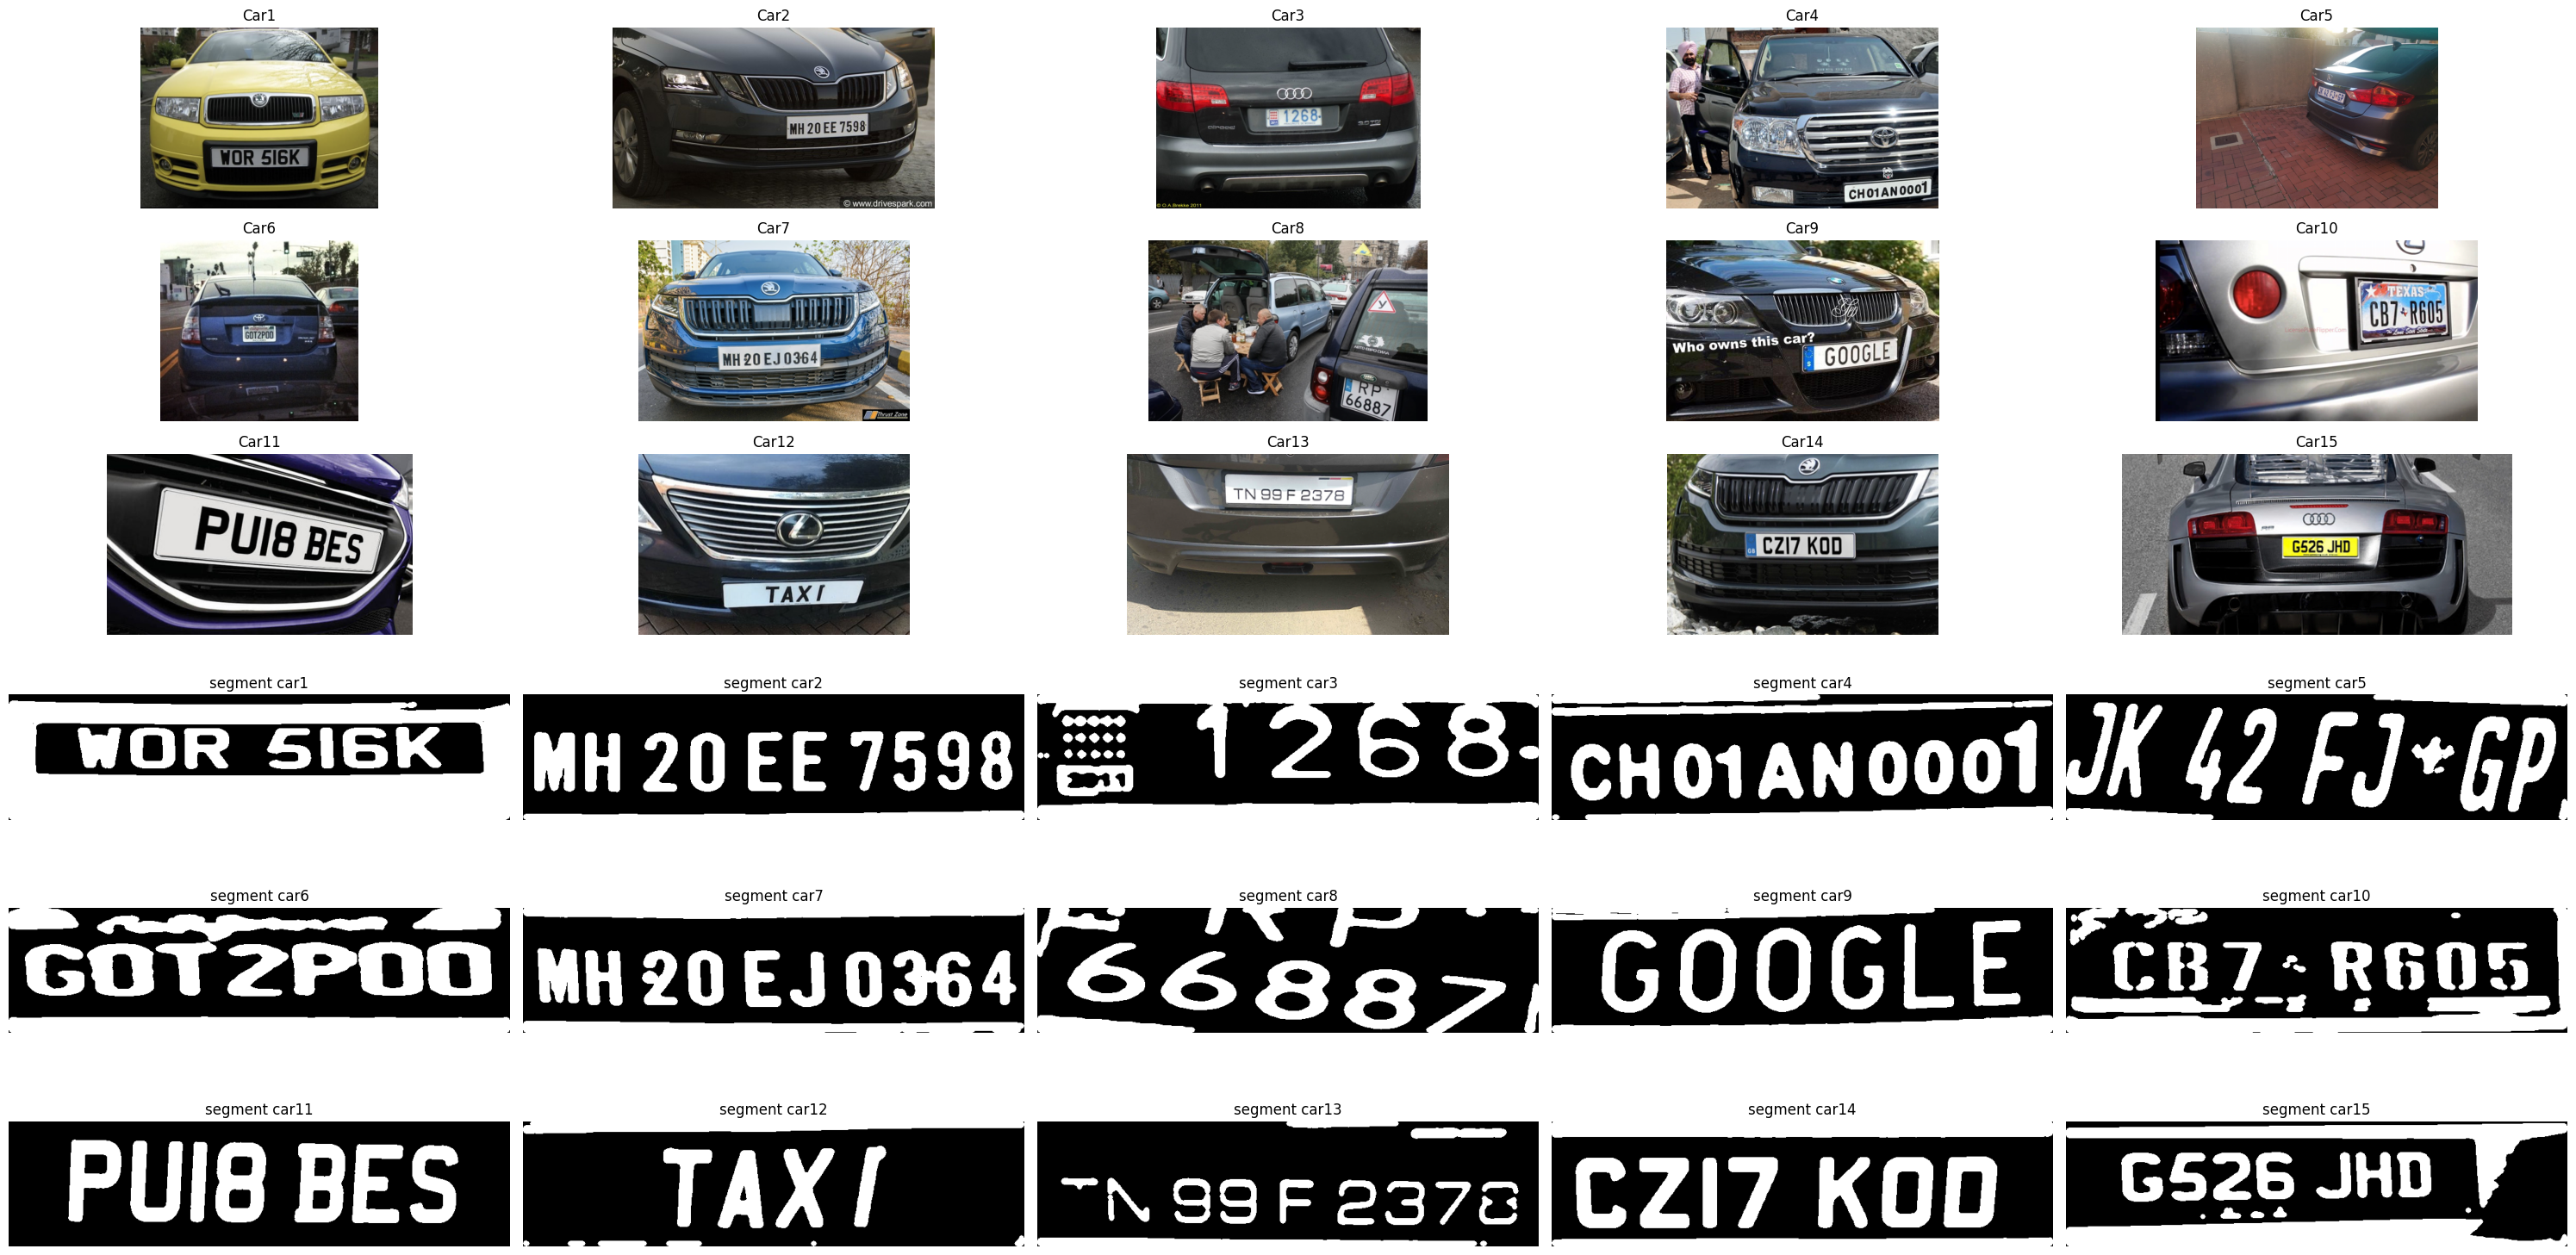

In [126]:
#Plot the 15 car photos in a 3x5 grid and save the figure as used in the report
fig, ax = plt.subplots(6, 5, figsize=(30, 15))
ax[0, 0].imshow(car1)
ax[0, 0].set_title('Car1')
ax[0, 1].imshow(car2)
ax[0, 1].set_title('Car2')
ax[0, 2].imshow(car3)
ax[0, 2].set_title('Car3')
ax[0, 3].imshow(car4)
ax[0, 3].set_title('Car4')
ax[0, 4].imshow(car5)
ax[0, 4].set_title('Car5')
ax[1, 0].imshow(car6)
ax[1, 0].set_title('Car6')
ax[1, 1].imshow(car7)
ax[1, 1].set_title('Car7')
ax[1, 2].imshow(car8)
ax[1, 2].set_title('Car8')
ax[1, 3].imshow(car9)
ax[1, 3].set_title('Car9')
ax[1, 4].imshow(car10)
ax[1, 4].set_title('Car10')
ax[2, 0].imshow(car11)
ax[2, 0].set_title('Car11')
ax[2, 1].imshow(car12)
ax[2, 1].set_title('Car12')
ax[2, 2].imshow(car13)
ax[2, 2].set_title('Car13')
ax[2, 3].imshow(car14)
ax[2, 3].set_title('Car14')
ax[2, 4].imshow(car15)
ax[2, 4].set_title('Car15')

ax[3, 0].imshow(easy_segmenter(car1), cmap='gray')
ax[3, 0].set_title('segment car1')
ax[3, 1].imshow(easy_segmenter(car2), cmap='gray')
ax[3, 1].set_title('segment car2')
ax[3, 2].imshow(easy_segmenter(car3), cmap='gray')
ax[3, 2].set_title('segment car3')
ax[3, 3].imshow(easy_segmenter(car4), cmap='gray')
ax[3, 3].set_title('segment car4')
ax[3, 4].imshow(easy_segmenter(car5), cmap='gray')
ax[3, 4].set_title('segment car5')
ax[4, 0].imshow(easy_segmenter(car6), cmap='gray')
ax[4, 0].set_title('segment car6')
ax[4, 1].imshow(easy_segmenter(car7), cmap='gray')
ax[4, 1].set_title('segment car7')
ax[4, 2].imshow(easy_segmenter(car8), cmap='gray')
ax[4, 2].set_title('segment car8')
ax[4, 3].imshow(easy_segmenter(car9), cmap='gray')
ax[4, 3].set_title('segment car9')
ax[4, 4].imshow(easy_segmenter(car10), cmap='gray')
ax[4, 4].set_title('segment car10')
ax[5, 0].imshow(easy_segmenter(car11), cmap='gray')
ax[5, 0].set_title('segment car11')
ax[5, 1].imshow(easy_segmenter(car12), cmap='gray')
ax[5, 1].set_title('segment car12')
ax[5, 2].imshow(easy_segmenter(car13), cmap='gray')
ax[5, 2].set_title('segment car13')
ax[5, 3].imshow(easy_segmenter(car14), cmap='gray')
ax[5, 3].set_title('segment car14')
ax[5, 4].imshow(easy_segmenter(car15), cmap='gray')
ax[5, 4].set_title('segment car15')


# Hide the axis
for a in ax.ravel():
    a.axis('off')

plt.tight_layout()
# Plot.savefig('Figures/Figure2.png', dpi=300, bbox_inches='tight')
plt.show()

# PROCEDURE

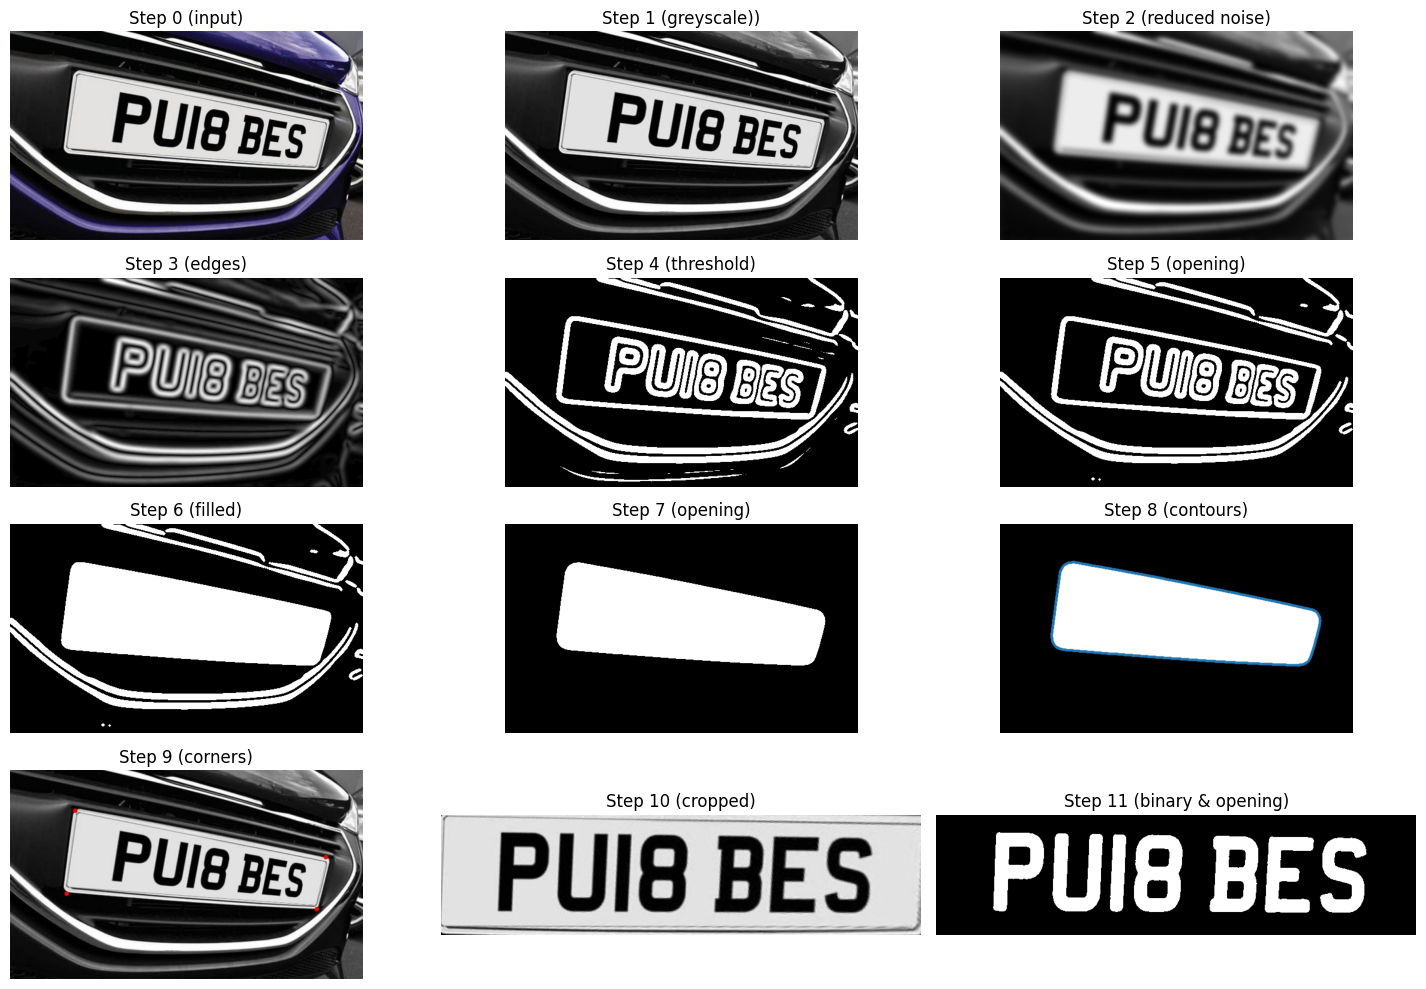

In [124]:
# The process and techniques of segmenting the license plate of the car showing in the steps
# democar = imread('CarImages/demo2.png', as_gray=False)
demoplate = easy_segmenter(car11, True)

# Plot the images in Figures/Steps as a 4x3 grid and save the figure as used in the report
fig, ax = plt.subplots(4, 3, figsize=(15, 10))
ax[0, 0].imshow(imread('Figures/Steps/step0.png', as_gray=False))
ax[0, 0].set_title('Step 0 (input)')
ax[0, 1].imshow(imread('Figures/Steps/step1.png', as_gray=True), cmap='gray')
ax[0, 1].set_title('Step 1 (greyscale))')
ax[0, 2].imshow(imread('Figures/Steps/step2.png', as_gray=True), cmap='gray')
ax[0, 2].set_title('Step 2 (reduced noise)')
ax[1, 0].imshow(imread('Figures/Steps/step3.png', as_gray=True), cmap='gray')
ax[1, 0].set_title('Step 3 (edges)')
ax[1, 1].imshow(imread('Figures/Steps/step4.png', as_gray=True), cmap='gray')
ax[1, 1].set_title('Step 4 (threshold)')
ax[1, 2].imshow(imread('Figures/Steps/step5.png', as_gray=True), cmap='gray')
ax[1, 2].set_title('Step 5 (opening)')
ax[2, 0].imshow(imread('Figures/Steps/step6.png', as_gray=True), cmap='gray')
ax[2, 0].set_title('Step 6 (filled)')
ax[2, 1].imshow(imread('Figures/Steps/step7.png', as_gray=True), cmap='gray')
ax[2, 1].set_title('Step 7 (opening)')
ax[2, 2].imshow(imread('Figures/Steps/step8.png', as_gray=False), cmap='gray')
ax[2, 2].set_title('Step 8 (contours)')
ax[3, 0].imshow(imread('Figures/Steps/step9.png', as_gray=False), cmap='gray')
ax[3, 0].set_title('Step 9 (corners)')
ax[3, 1].imshow(imread('Figures/Steps/step10.png', as_gray=True), cmap='gray')
ax[3, 1].set_title('Step 10 (cropped)')
ax[3, 2].imshow(imread('Figures/Steps/step11.png', as_gray=True), cmap='gray')
ax[3, 2].set_title('Step 11 (binary & opening)')

for a in ax.ravel():
    a.axis('off')

plt.tight_layout()
# plt.savefig('Figures/Figure3.png', dpi=300, bbox_inches='tight')
plt.show()